## This program takes an input image and processes it against the stored CNN model and the co-ordinates of the parking slots and returns an image with the empty slots marked in green.

In [16]:
pip install import_ipynb

Note: you may need to restart the kernel to use updated packages.


In [1]:
#Import the necessary Python Libraries
from __future__ import division
import cv2
import os, glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pickle
import webcolors
import json
from sklearn.cluster import KMeans

from keras.applications.imagenet_utils import preprocess_input
from keras.models import load_model

#Import the config file
import import_ipynb 
import Config as c

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

importing Jupyter notebook from Config.ipynb


In [2]:
#Global Variables
#Define the 2 class lables for the slots
class_dictionary = {}
class_dictionary[0] = 'empty'
class_dictionary[1] = 'occupied'

empty_slots=[]
empty_slot_name = []

In [3]:
#Load the stored the parking slot co-ordinates 
with open(c.pickle_file, 'rb') as handle:
    final_spot_dict = pickle.load(handle)

In [4]:
#Define the various Methods

import pandas as pd 
def dominantColors(image,clusters):
    
    #convert to rgb from bgr
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    #reshaping to a list of pixels
    img = img.reshape((img.shape[0] * img.shape[1], 3))

    #using k-means to cluster pixels
    kmeans = KMeans(n_clusters = clusters)
    kmeans.fit(img)

    #the cluster centers are our dominant colors.
    colors = kmeans.cluster_centers_

    #save labels
    labels = kmeans.labels_

    #returning after converting to integer from float
    return colors

# Method to show a set of images
def show_images(images, cmap=None):
    cols = 2
    rows = (len(images)+1)//cols
    
    plt.figure(figsize=(15, 12))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        # use gray scale color map if there is only one channel
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

# Find the closet color for an RGB tupe passed
def closest_colour(requested_colour):
    min_colours = {}
    for key, name in webcolors.CSS3_HEX_TO_NAMES.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(key)
        rd = (r_c - requested_colour[0]) ** 2
        gd = (g_c - requested_colour[1]) ** 2
        bd = (b_c - requested_colour[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    return min_colours[min(min_colours.keys())]

def get_colour_name(requested_colour):
    try:
        closest_name = actual_name = webcolors.rgb_to_name(requested_colour)
    except ValueError:
        closest_name = closest_colour(requested_colour)
        actual_name = None
    return actual_name, closest_name

# This method takes an image of a parking slot and returns the class label    
def make_prediction_on_input_slot(image):
    #Rescale image
    img = image/255.

    #Convert to a 4D tensor
    image = np.expand_dims(img, axis=0)

    # make predictions on the preloaded model
    class_predicted = model.predict(image)
    inID = np.argmax(class_predicted[0])
    label = class_dictionary[inID]
    return label  

# Method to take an image of a parking lot and then return an image which shows the slots which are empty
def predict_empty_slots(image, spot_dict=final_spot_dict, color= c.slot_color, make_copy=True, alpha=0.5, save=False):
    if make_copy:
        new_image = np.copy(image)
        overlay = np.copy(image)
        overlay_no = np.copy(image)
    cnt_empty = 0
    all_spots = 0
    data={}
    data['slot'] = []
    actual_color = ""
    closest_color = ""
 
    # Find the slots from the stored slot co-ordinates and then pass each slot into the model to find the class label
    for spot in spot_dict.keys():
        all_spots = all_spots + 1
        (x1, y1, x2, y2) = spot
        (x1, y1, x2, y2) = (int(x1), int(y1), int(x2), int(y2))
        cx = (x1+x2)/2
        cy = (y1+y2)/2
        cv2.circle(new_image, (int(cx),int(cy)), 5, (255,0,0), 20)
        
        #crop the image to get the image only for the slot and resize  
        spot_img = image[y1:y2, x1:x2]
        spot_img = cv2.resize(spot_img, (c.image_width,c.image_height)) 
        
        if all_spots in c.no_slot_list:
            continue
        
        else:
            # find the label for the slot image
            label = make_prediction_on_input_slot(spot_img)
            if label == 'empty':
                if all_spots in c.reserve_list:
                    cv2.rectangle(overlay_no, (int(x1),int(y1)), (int(x2),int(y2)), [255,0,0], -1)
                else:
                    cv2.rectangle(overlay, (int(x1),int(y1)), (int(x2),int(y2)), color, -1)
                    coordinate=x1,y1,x2,y2
                    empty_slots.append(coordinate)
                    cnt_empty = cnt_empty + 1
                    empty_slot_name.append(pd.read_pickle('spot_dict.pickle')[coordinate])
                    
                    
        #Step 1 : Find the central co-ordinates
        cx = (x1+x2)/2
        cy = (y1+y2)/2
        
        #Step 2: Check if the sopt is occupied or empty
        occupancy = 0
        
        #step 3 : find the color of the image
        if label == 'occupied':
            occupancy=1
            im = Image.open('./test_images/test4.jpg') 
            pix = im.load() 
            rgb_value = pix[cx,cy]
            #closet_color = webcolors.rgb_to_name(rgb_value)
                    
            #img = 'colors.jpg'
            clusters = 5
            colors = dominantColors(spot_img, clusters)
            #print(colors[0])
            rgb_value = colors[0]
            actual_color, closest_color = get_colour_name(rgb_value)
            
            #print(closest_color)
            if 'white' in closest_color:
                closest_color = 'white'
            elif 'silver' in closest_color:
                closest_color = 'silver'
            elif 'black' in closest_color:
                closest_color = 'black'
            
            elif 'blue' in closest_color:
                closest_color = 'blue'
            elif 'red' in closest_color:
                closest_color = 'red'
            elif 'brown' in closest_color:
                closest_color = 'brown'
            elif 'green' in closest_color:
                closest_color = 'green'
            elif 'grey' in closest_color:
                closest_color = 'grey'
            else:
                closest_color = 'others'
        #closest_color = colors[0]
        #print(closest_color)

        
        #Step 4 : Find the orientation of the vehicle
        #orientation = predict_orientation(spot_image)
        
        data['slot'].append({
        "Slot" : all_spots,
        "cx" : cx,
        "cy" : cy,
        "v" : occupancy,
        "c" : closest_color,
        "p" : ""
        })
    
    with  open(c.json_file,'w') as outfile:
        json.dump(data, outfile)

    #Put a message for the number of empty slots
    cv2.addWeighted(overlay, alpha, new_image, 1 - alpha, 0, new_image)
    cv2.addWeighted(overlay_no, alpha, new_image, 1 - alpha, 0, new_image)
 
    #Store the overlayed image
    if save:
        filename = c.filename_with_marker
        cv2.imwrite(filename, new_image)
    
    return new_image




1/1 [==============================] - 0s 48ms/step
No of Empty slots -  17  out of total -  103


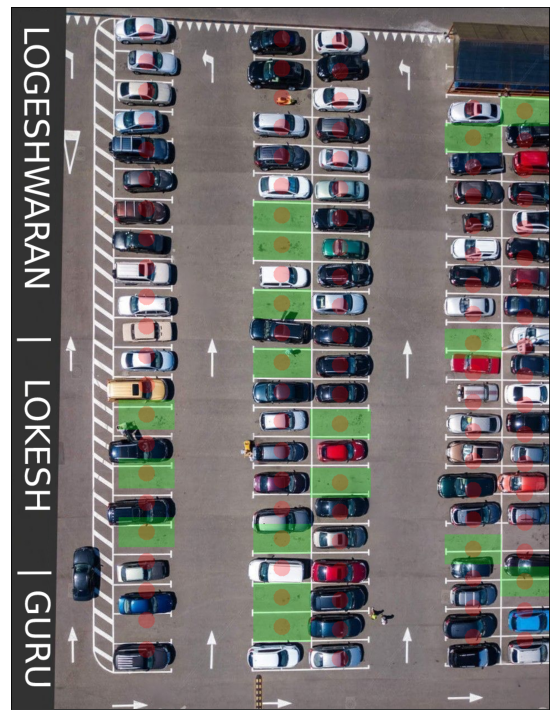

In [5]:
#Processing for a new Image
# Load the input image from the folder
input_image = [plt.imread(path) for path in glob.glob(c.img_path)]

#Load the stored CNN model
model = load_model(c.model_file)

# Get the processed iamge with the empty slots marked 
predicted_image = list(map(predict_empty_slots, input_image))

print('No of Empty slots - ' , len(empty_slots), ' out of total - ', len(final_spot_dict))
show_images(predicted_image)

In [6]:
len(empty_slot_name)

17

In [7]:
empty_slots

[(194, 710, 294, 763),
 (194, 816, 294, 869),
 (194, 922, 294, 975),
 (437, 351, 540, 404),
 (437, 404, 540, 457),
 (437, 510, 540, 563),
 (437, 616, 540, 669),
 (437, 934, 540, 987),
 (437, 1040, 540, 1093),
 (437, 1093, 540, 1146),
 (539, 727, 648, 780),
 (539, 833, 648, 886),
 (782, 211, 884, 264),
 (782, 582, 884, 635),
 (782, 953, 884, 1006),
 (882, 163, 971, 216),
 (882, 1011, 971, 1064)]

In [8]:
df=pd.read_pickle('spot_dict.pickle')
df

{(194, 21, 294, 74): 1,
 (194, 74, 294, 127): 2,
 (194, 127, 294, 180): 3,
 (194, 180, 294, 233): 4,
 (194, 233, 294, 286): 5,
 (194, 286, 294, 339): 6,
 (194, 339, 294, 392): 7,
 (194, 392, 294, 445): 8,
 (194, 445, 294, 498): 9,
 (194, 498, 294, 551): 10,
 (194, 551, 294, 604): 11,
 (194, 604, 294, 657): 12,
 (194, 657, 294, 710): 13,
 (194, 710, 294, 763): 14,
 (194, 763, 294, 816): 15,
 (194, 816, 294, 869): 16,
 (194, 869, 294, 922): 17,
 (194, 922, 294, 975): 18,
 (194, 975, 294, 1028): 19,
 (194, 1028, 294, 1081): 20,
 (194, 1081, 294, 1134): 21,
 (194, 1134, 294, 1187): 22,
 (437, 33, 540, 86): 23,
 (437, 86, 540, 139): 24,
 (437, 139, 540, 192): 25,
 (437, 192, 540, 245): 26,
 (437, 245, 540, 298): 27,
 (437, 298, 540, 351): 28,
 (437, 351, 540, 404): 29,
 (437, 404, 540, 457): 30,
 (437, 457, 540, 510): 31,
 (437, 510, 540, 563): 32,
 (437, 563, 540, 616): 33,
 (437, 616, 540, 669): 34,
 (437, 669, 540, 722): 35,
 (437, 722, 540, 775): 36,
 (437, 775, 540, 828): 37,
 (437, 82

In [9]:
for i in range(len(empty_slots)):
    print(df[empty_slots[i]])

14
16
18
29
30
32
34
40
42
43
57
59
67
74
81
85
101
